In [1]:
from decouple import config
import os
import seaborn as sns
sns.set_style('darkgrid')
import pandas as pd
from nilearn import datasets, plotting, image 
from fNeuro.connectivity.connectivity import Cyclic_analysis, connectome_plotting, cyclic_order
import fNeuro.processing.processing as processing
from fNeuro.bayesian.bayesian import z_score_to_bayes_factor, logistic_to_bayes_factor 
from fNeuro.utils.pickling import load_pickle
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
resting_path = config('resting')
time_series = load_pickle(os.path.join(resting_path, 'measures', 'time_series'))
an_time_series = time_series['an']
hc_time_series = time_series['hc']
msdl = datasets.fetch_atlas_msdl()
msdl_overview_df = pd.DataFrame({'labels': msdl['labels'],
                                  'networks': msdl['networks'],
                                  'region_coords': msdl['region_coords']
                                  })

In [3]:
group = np.asarray(an_time_series + hc_time_series)
label = np.asarray([0 for sub in range(len(an_time_series))] + [1 for sub in range(len(hc_time_series))])

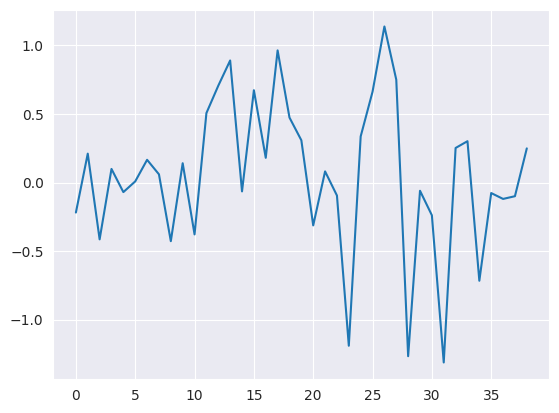

In [4]:
plt.plot(an_time_series[0][3])
plt.show()

## Get the most accurate model

Load in the models from memory

In [5]:
connectome = load_pickle(os.path.join(resting_path, 'measures', 'connectome'))
svc = load_pickle(os.path.join(resting_path, 'measures', 'svc_model'))
logistic = load_pickle(os.path.join(resting_path, 'measures', 'logistic_model'))
random_forest = load_pickle(os.path.join(resting_path, 'measures', 'random_forest_model'))
dec_tree = load_pickle(os.path.join(resting_path, 'measures', 'tree_model'))
stacked = load_pickle(os.path.join(resting_path, 'measures', 'stacked_model'))

Plot the accuracy of all  ml models

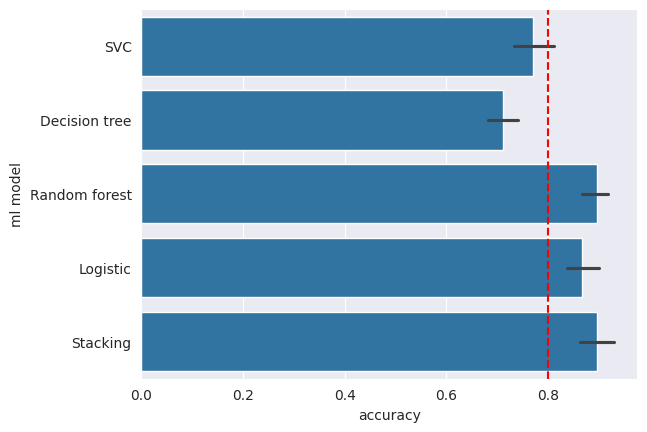

In [6]:
overal_score = {'Accuracy': pd.DataFrame(data={
                                                'SVC': svc['Accuracy'],
                                                'Decision tree': dec_tree['Accuracy'],
                                                'Random forest': random_forest['Accuracy'],
                                                'Logistic': logistic['Accuracy'],
                                                'Stacking': stacked['Accuracy'],
                                                }),
                'AUC': pd.DataFrame(data={
                                                'SVC': svc['ROC_AUC'],
                                                'Decision tree': dec_tree['ROC_AUC'],
                                                'Random forest': random_forest['ROC_AUC'],
                                                'Logistic': logistic['ROC_AUC'], 
                                                'Stacking': stacked['ROC_AUC']
                                                })
}

accuracy_plot = sns.barplot(data=pd.melt(overal_score['Accuracy']).rename(columns={'variable': 'ml model', 'value': 'accuracy'}), 
                   x='accuracy', y='ml model')
accuracy_plot.axvline(0.8, color="red", linestyle="--")

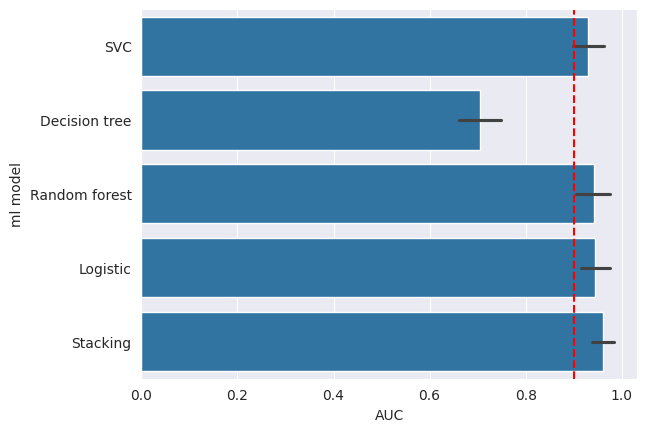

In [7]:
auc = sns.barplot(data=pd.melt(overal_score['AUC']).rename(columns={'variable': 'ml model', 'value': 'AUC'}), 
                   x='AUC', y='ml model')
auc.axvline(0.9, color="red", linestyle="--")

In [8]:
overal_score['Accuracy'].mean()

SVC              0.770370
Decision tree    0.711111
Random forest    0.896296
Logistic         0.866667
Stacking         0.896296
dtype: float64

In [9]:
overal_score['AUC'].mean()

SVC              0.930769
Decision tree    0.705769
Random forest    0.942857
Logistic         0.943956
Stacking         0.962088
dtype: float64

### Comparing cyclic analysis to other connectivity analysis

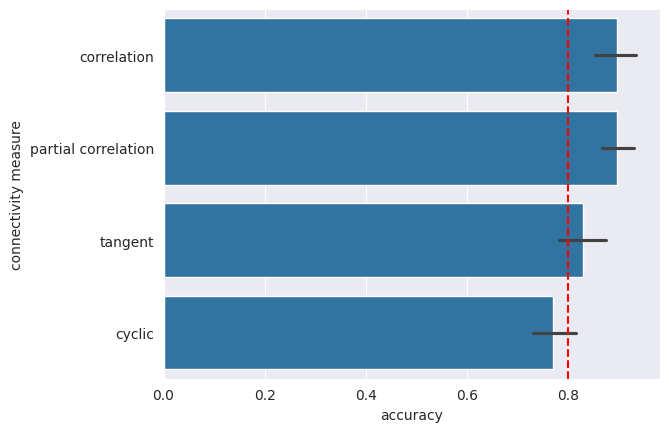

In [10]:
comp_scores = load_pickle(os.path.join(resting_path, 'measures', 'svc_comparison'))
del(comp_scores['cyclic']['model'])
comp_score_dict = {'Accuracy': pd.DataFrame(data={
                                                'correlation': comp_scores['correlation'][0]['Accuracy'],
                                                'partial correlation': comp_scores['partial correlation'][0]['Accuracy'],
                                                'tangent': comp_scores['tangent'][0]['Accuracy'],
                                                'cyclic': comp_scores['cyclic']['Accuracy'],
                                                }),
                'AUC': pd.DataFrame(data={
                                            'correlation': comp_scores['correlation'][0]['ROC_AUC'],
                                            'partial correlation': comp_scores['partial correlation'][0]['ROC_AUC'],
                                            'tangent': comp_scores['tangent'][0]['ROC_AUC'],
                                            'cyclic': comp_scores['cyclic']['ROC_AUC'],
                                                })
}

accuracy_plot = sns.barplot(data=pd.melt(comp_score_dict['Accuracy']).rename(columns={'variable': 'connectivity measure', 'value': 'accuracy'}), 
                   x='accuracy', y='connectivity measure')
accuracy_plot.axvline(0.8, color="red", linestyle="--")

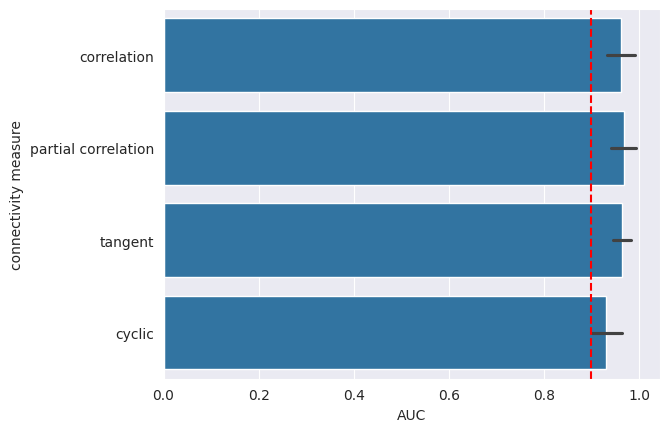

In [11]:
auc = sns.barplot(data=pd.melt(comp_score_dict['AUC']).rename(columns={'variable': 'connectivity measure', 'value': 'AUC'}), 
                   x='AUC', y='connectivity measure')
auc.axvline(0.9, color="red", linestyle="--")

### Examine weights and correlations

First get the full correlation matrix then get the mean correlations of group. Get the names of all the correlations and finally get the mean correlation values 

In [12]:
full_correlation_matrix = Cyclic_analysis(to_vectorize=False).fit(group)
an_mean_correlations = pd.DataFrame(full_correlation_matrix[0:66].mean(axis=0))
an_mean_correlations.columns = msdl['labels']
an_mean_correlations.index = msdl['labels']

hc_mean_correlations = pd.DataFrame(full_correlation_matrix[66:].mean(axis=0))
hc_mean_correlations.columns = msdl['labels']
hc_mean_correlations.index = msdl['labels']


Get the correlation names, network names and values by group 

In [13]:
an_df_corr = an_mean_correlations.where(np.tril(an_mean_correlations).astype(bool))
an_df = an_df_corr.stack().reset_index().rename(columns={0: 'correlation'})
an_df['corr_names'] = an_df['level_1'] + ' - ' + an_df['level_0']
an_df = an_df.drop(an_df[an_df['level_0'] == an_df['level_1']].index).drop(columns=['level_0', 'level_1'])
an_df = an_df[an_df.columns[::-1]]

network_names = []
for correlation in an_df['corr_names']:
    splitted_name = correlation.split('-')
    region_one = splitted_name[0].rstrip()
    region_two = splitted_name[1].lstrip()
    network_one = msdl_overview_df[msdl_overview_df['labels'] == region_one]['networks'].values[0]
    network_two = msdl_overview_df[msdl_overview_df['labels'] == region_two]['networks'].values[0]
    network_names.append(f"{network_one} - {network_two}")

an_df['network_names'] = network_names

hc_df_corr = hc_mean_correlations.where(np.tril(hc_mean_correlations).astype(bool))
hc_df = hc_df_corr.stack().reset_index().rename(columns={0: 'correlation'})
hc_df['corr_names'] = hc_df['level_1'] + ' - ' + hc_df['level_0']
hc_df = hc_df.drop(hc_df[hc_df['level_0'] == hc_df['level_1']].index).drop(columns=['level_0', 'level_1'])
hc_df = hc_df[hc_df.columns[::-1]]
hc_df['network_names'] = network_names

Get the biomarker information

In [14]:
markers_df = pd.DataFrame(data={
                            'correlation_names': an_df['corr_names'],
                            'network': an_df['network_names'],
                            'rf_importance': stacked['model'].named_estimators_.rf.feature_importances_,
                              })
markers_df['log_coeffiecents'] = stacked['model'].named_estimators_.log.coef_.T
markers_df['Bayes'] = markers_df['log_coeffiecents'].apply(lambda coef: logistic_to_bayes_factor(coef))

Segregate the biomarker dataframe by network 

In [15]:
network_values = dict(zip([network for network in msdl_overview_df['networks'].unique()], 
                          [{} for network in msdl_overview_df['networks'].unique()]))
for network in network_values.keys():
    network_df = markers_df[markers_df['network'].str.startswith(network)]
    within_network_df = network_df[network_df['network'] == f'{network} - {network}'] 
    between_network_df = network_df.drop(within_network_df.index).reset_index(drop=True) 
    network_values[network]['within'] = within_network_df
    network_values[network]['between'] = between_network_df

Calculate the mean of each network and between each network

In [16]:
within_network = dict(zip([network for network in msdl_overview_df['networks'].unique()], 
                          [{} for network in msdl_overview_df['networks'].unique()]))
for get_mean in network_values.keys():
    if len(network_values[get_mean]['within']) > 0:
        within_network[get_mean]['rf_importance'] = network_values[get_mean]['within']['rf_importance'].mean()
        within_network[get_mean]['log_coeffiecents'] = network_values[get_mean]['within']['log_coeffiecents'].mean()

between_network_list  =[network_values[df]['between'] for df in network_values.keys()]
between_network = pd.concat(between_network_list).reset_index(drop=True)

In [17]:
within_network_df = pd.DataFrame(within_network).T.dropna()
within_network_df = processing.df_with_transformed_values(within_network_df)
most_predicitive_within_network = processing.get_max_value(within_network_df)
most_predicitive_within_network['an_corr'] = an_df[an_df['network_names'].str.contains(f'{most_predicitive_within_network.index[0]} - {most_predicitive_within_network.index[0]}')]['correlation'].mean()
most_predicitive_within_network['hc_corr'] = hc_df[hc_df['network_names'].str.contains(f'{most_predicitive_within_network.index[0]} - {most_predicitive_within_network.index[0]}')]['correlation'].mean()
most_predicitive_within_network

,rf_importance,log_coeffiecents,z_score_transformation_rf,z_score_transformation_log,an_corr,hc_corr
Temporal,0.00299,-0.010267,2.120604,-1.90228,0.914226,-2.397495


In [18]:
within_network_prediction = network_values[most_predicitive_within_network.index[0]]['within']
within_network_prediction = processing.df_with_transformed_values(within_network_prediction)
most_predicitive_within_network_node = processing.get_max_value(within_network_prediction)
most_predicitive_within_network_node['an_corr'] = an_df[an_df['corr_names'] == most_predicitive_within_network_node['correlation_names'].values[0]]['correlation'].values[0]
most_predicitive_within_network_node['hc_corr'] = hc_df[hc_df['corr_names'] == most_predicitive_within_network_node['correlation_names'].values[0]]['correlation'].values[0]
most_predicitive_within_network_node

,correlation_names,network,rf_importance,log_coeffiecents,Bayes,z_score_transformation_rf,z_score_transformation_log,an_corr,hc_corr
350,L STS - R STS,Temporal - Temporal,0.00299,-0.010267,1.000053,0.0,0.0,0.914226,-2.397495


In [19]:
between_network_df = processing.df_with_transformed_values(between_network)
most_predicitive_between_network = processing.get_max_value(between_network_df)
most_predicitive_between_network['an_corr'] = an_df[an_df['corr_names'] == most_predicitive_between_network['correlation_names'].values[0]]['correlation'].values[0]
most_predicitive_between_network['hc_corr'] = hc_df[hc_df['corr_names'] == most_predicitive_between_network['correlation_names'].values[0]]['correlation'].values[0]
most_predicitive_between_network

,correlation_names,network,rf_importance,log_coeffiecents,Bayes,z_score_transformation_rf,z_score_transformation_log,an_corr,hc_corr
318,R Post Temp - L IPS,R V Att - D Att,0.014284,-0.022843,1.000261,6.77586,-2.259002,1.527794,-5.741804


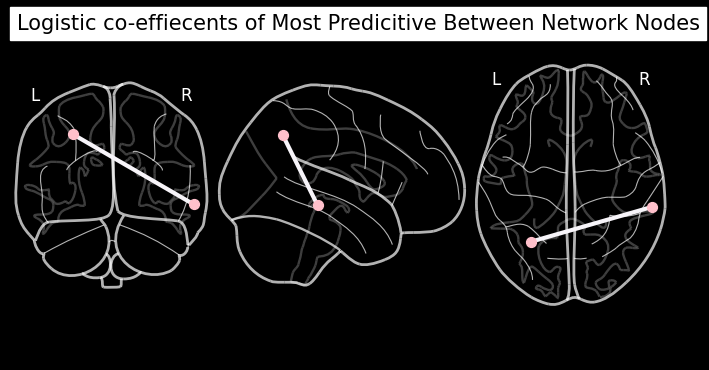

In [20]:
plot_parameters = connectome_plotting(most_predicitive_between_network, 'log_coeffiecents', msdl_overview_df)
plotting.plot_connectome(plot_parameters['adj'], 
                         plot_parameters['coords'],   
                         node_color='pink',
                         node_size=50,
                         edge_cmap='PuRd',
                         black_bg=True, 
                         title='Logistic co-effiecents of Most Predicitive Between Network Nodes')

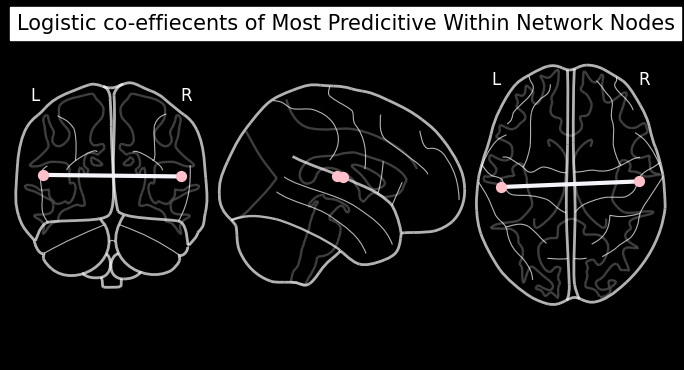

In [21]:
plot_parameters = connectome_plotting(most_predicitive_within_network_node, 'log_coeffiecents', msdl_overview_df)
plotting.plot_connectome(plot_parameters['adj'], 
                         plot_parameters['coords'],   
                         node_color='pink',
                         node_size=50,
                         edge_cmap='PuRd',
                         black_bg=True, 
                         title='Logistic co-effiecents of Most Predicitive Within Network Nodes')

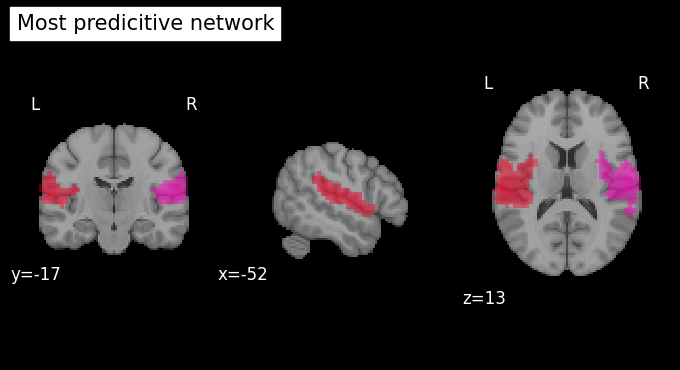

In [22]:
plotting.plot_prob_atlas(
    image.index_img(
        msdl['maps'], 
        msdl_overview_df[msdl_overview_df['networks'].str.contains(most_predicitive_within_network.index[0])].index.to_list()
        ),
    draw_cross=False,
    black_bg=True,
    cut_coords=msdl_overview_df[msdl_overview_df['networks'].str.contains(most_predicitive_within_network.index[0])]['region_coords'].to_list()[0],
    cmap='gist_rainbow',
    title='Most predicitive network'
)


Sort out the AN and HC correlations into one DataFrame 

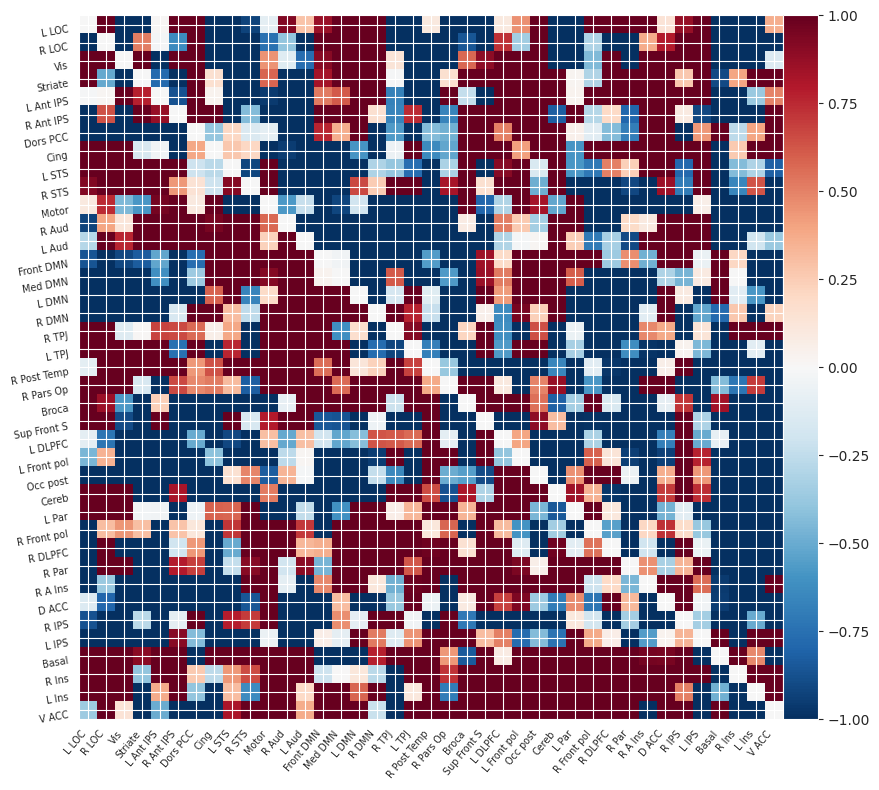

In [23]:
plotting.plot_matrix(
    an_mean_correlations.values,
    figure=(10, 8),
    labels=msdl['labels'],
    vmax=1,
    vmin=-1,
    reorder=True,
)

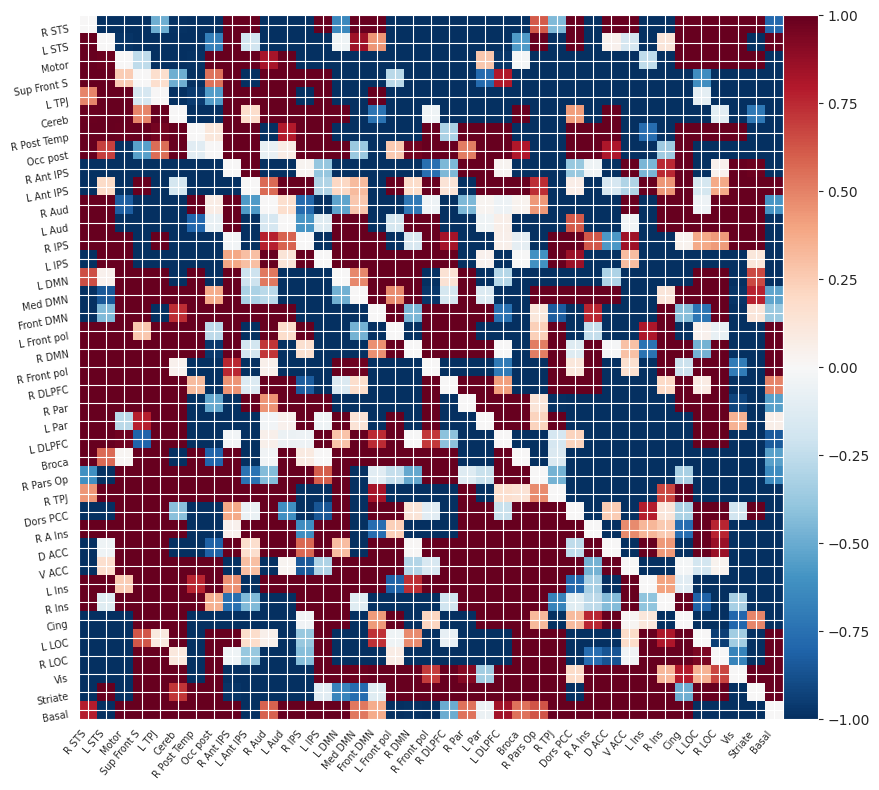

In [24]:
plotting.plot_matrix(
    hc_mean_correlations.values,
    figure=(10, 8),
    labels=msdl['labels'],
    vmax=1,
    vmin=-1,
    reorder=True,
)

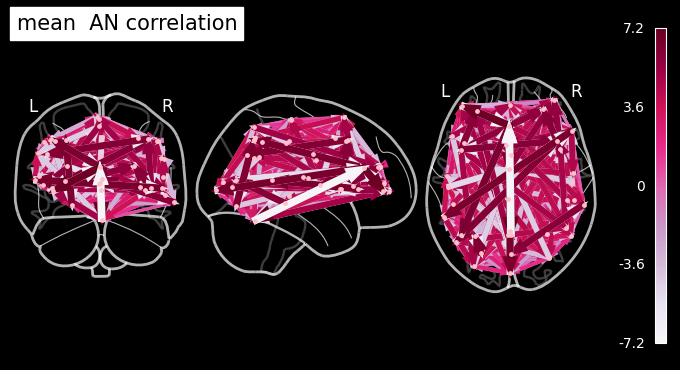

In [25]:
plotting.plot_connectome(
    an_mean_correlations.values,
    msdl['region_coords'],
    title="mean  AN correlation",
    node_color='pink',
    node_size=6,
    edge_cmap='PuRd',
    black_bg=True,
    colorbar=True
)

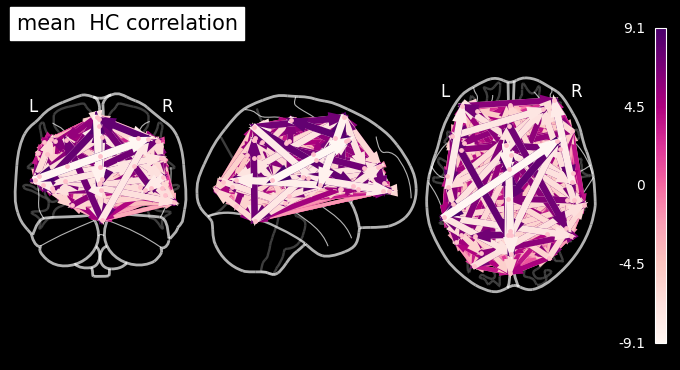

In [26]:
plotting.plot_connectome(
    hc_mean_correlations.values,
    msdl['region_coords'],
    title="mean  HC correlation",
    node_color='pink',
    node_size=6,
    edge_cmap='RdPu',
    black_bg=True,
    colorbar=True
)

In [27]:
an_lead_lag = full_correlation_matrix[0:66]
hc_lead_lag = full_correlation_matrix[66:]

In [28]:
an_orders = cyclic_order(an_mean_correlations, 0)
an_orders

,regions,eigenvalue_moduli,leading_eigenvector,leading_eigenvector_component_phases
0,R Ins,1.034168e-15,-0.313551-0.000000j,-3.141593
1,L STS,3.408520e+00,-0.077017-0.002870j,-3.104346
2,Basal,9.008281e+00,-0.127169-0.014198j,-3.030403
3,Cing,6.511099e-01,-0.165688-0.021644j,-3.011696
4,Striate,3.020410e+01,-0.182009-0.029437j,-2.981246
5,L Aud,3.713944e+01,-0.022791-0.058802j,-1.940553
6,R TPJ,1.762959e+00,0.021587-0.040484j,-1.080928
7,R Post Temp,9.008281e+00,0.092071+0.012293j,0.132728
8,R IPS,6.358165e+00,0.122316+0.033702j,0.268863
9,Med DMN,2.421916e+01,0.098790+0.048109j,0.453179


In [29]:
hc_orders = cyclic_order(hc_mean_correlations, 0)
hc_orders

,regions,eigenvalue_moduli,leading_eigenvector,leading_eigenvector_component_phases
0,Sup Front S,2.637773e+00,-0.306304-0.000000j,-3.141593
1,R Post Temp,1.410904e+01,-0.038660-0.005244j,-3.006776
2,L DMN,3.722336e+01,-0.079673-0.018416j,-2.914437
3,L DLPFC,1.182275e+01,-0.142836-0.036051j,-2.894361
4,R Front pol,1.552408e+01,-0.114713-0.037259j,-2.827544
5,R Par,1.552408e+01,-0.190831-0.092594j,-2.689843
6,R TPJ,2.373279e+00,-0.162003-0.100044j,-2.588373
7,L Par,1.182275e+01,-0.141734-0.092733j,-2.562220
8,Broca,2.637773e+00,-0.126226-0.111455j,-2.418261
9,L Front pol,1.092702e+01,-0.103511-0.106051j,-2.344078
